## Imports for Predicting Approval or rejection


In [ ]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay
)
from joblib import dump

pd.set_option("display.max_columns", 100)
RANDOM_STATE = 42


ROOT     = Path("..").resolve() if Path.cwd().name == "notebooks" else Path(".").resolve()
DATA_RAW = ROOT / "data" / "raw"
MODELS   = ROOT / "models"
REPORTS  = ROOT / "reports"
for d in [DATA_RAW, MODELS, REPORTS]:
    d.mkdir(parents=True, exist_ok=True)

CSV_PATH = DATA_RAW / "loan_approval_dataset.csv"
assert CSV_PATH.exists(), f"CSV not found at {CSV_PATH}"


## Load data & quick peek
#### confirm rows/columns and spot obvious issues early.

In [64]:
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()

(4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## Clean column names, choose target, map labels ->{0,1}
### Binary target for classification

In [65]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r"\s+", "_", regex=True)
      .str.replace("/", "_")
      .str.replace("-", "_")
)
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [66]:
target_col = "loan_status" if "loan_status" in df.columns else df.columns[-1]
print(f"Target column: {target_col}")

Target column: loan_status


In [67]:
def map_binary_strict(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip().str.lower()
    pos = {"approve","approved","y","yes","1","true"}
    neg = {"reject","rejected","n","no","0","false"}
    return s.map(lambda v: 1 if v in pos else (0 if v in neg else np.nan))

y = map_binary_strict(df[target_col])
keep = ~y.isna()
df = df.loc[keep].copy()
y = y.loc[df.index].astype(int)

print("Rows after cleaning:", df.shape[0])
y.value_counts(normalize=True).rename({0:"Reject",1:"Approve"}) * 100

Rows after cleaning: 4269


loan_status
Approve    62.215976
Reject     37.784024
Name: proportion, dtype: float64

## Data Audit and finding null values

In [68]:
missing = df.isna().mean().sort_values(ascending=False)
schema = pd.DataFrame({"dtype": df.dtypes, "missing_ratio": missing})
schema

,dtype,missing_ratio
loan_id,int64,0.0
no_of_dependents,int64,0.0
education,object,0.0
self_employed,object,0.0
income_annum,int64,0.0
loan_amount,int64,0.0
loan_term,int64,0.0
cibil_score,int64,0.0
residential_assets_value,int64,0.0
commercial_assets_value,int64,0.0


## Split Train/Test

In [69]:
X = df.drop(columns=[target_col])
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

len(X_train), len(X_test), len(num_cols), len(cat_cols)


(3415, 854, 10, 2)

## Preprocessing + Random Forest pipeline

In [70]:

numeric = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()) 
])

categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric, num_cols),
    ("cat", categorical, cat_cols)
])

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)

rf_pipe = Pipeline([
    ("prep", preprocess),
    ("model", rf)
])


## Train the model

In [71]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_id',
                                                   'no_of_dependents',
                                                   'income_annum',
                                                   'loan_amount', 'loan_term',
                                                   'cibil_score',
                                                   'residential_assets_value',
                                                   'commercial_assets_value',
                                                   'luxury_assets_value',
                                                   'bank_asset_value']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['education',
                                                   'self_employed'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=400, n_jobs=-1,
                                        random_state=42))])

## XGBoost training

In [72]:
from xgboost import XGBClassifier
import numpy as np
from sklearn.pipeline import Pipeline

pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos_weight = (neg / pos) if pos > 0 else 1.0

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.08,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="binary:logistic",
    tree_method="hist",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    scale_pos_weight=scale_pos_weight
)

xgb_pipe = Pipeline([
    ("prep", preprocess),
    ("model", xgb)
])

xgb_pipe.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_id',
                                                   'no_of_dependents',
                                                   'income_annum',
                                                   'loan_amount', 'loan_term',
                                                   'cibil_score',
                                                   'residential_assets_value',
                                                   'commercial_assets_value',
                                                   'luxury_assets_value',
                                                   'bank_asset_value']),
                                                 ('cat',
                                                  Pipeline...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.08,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

## Evalute (Accuracy)
### Precision, recall, F1, Auc to get clear picture

In [73]:
y_pred = rf_pipe.predict(X_test)
y_prob = rf_pipe.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_prob)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["Reject","Approve"]))


Accuracy : 0.9824
Precision: 0.9850
Recall   : 0.9868
F1-score : 0.9859
ROC AUC  : 0.9984

Classification report:
              precision    recall  f1-score   support

      Reject       0.98      0.98      0.98       323
     Approve       0.98      0.99      0.99       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



In [74]:
## comparison table for RF vs XGB
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def eval_model(pipe, X, y):
    y_pred = pipe.predict(X)
    y_prob = pipe.predict_proba(X)[:, 1]
    return {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred, zero_division=0),
        "recall": recall_score(y, y_pred, zero_division=0),
        "f1": f1_score(y, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y, y_prob),
    }

results = pd.DataFrame({
    "Random Forest": eval_model(rf_pipe, X_test, y_test),
    "XGBoost":       eval_model(xgb_pipe, X_test, y_test),
}).T

results = results[["accuracy","precision","recall","f1","roc_auc"]].sort_values("accuracy", ascending=False)
results.style.format("{:.4f}")



,accuracy,precision,recall,f1,roc_auc
Random Forest,0.9824,0.9850,0.9868,0.9859,0.9984
XGBoost,0.9813,0.9849,0.9849,0.9849,0.9978


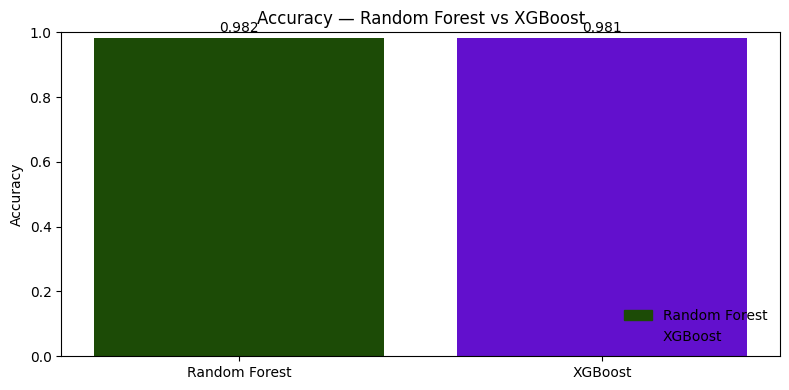

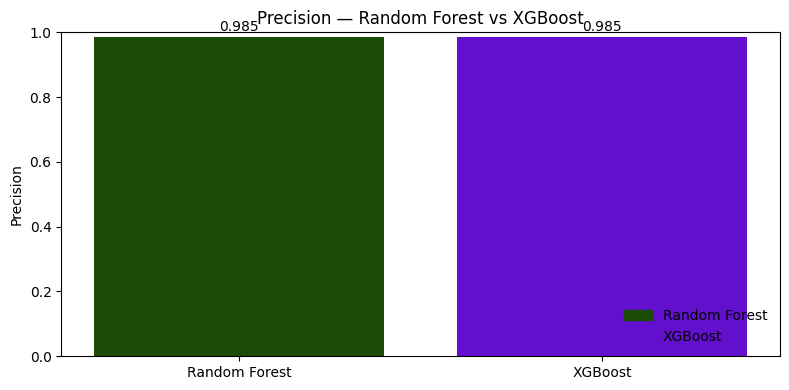

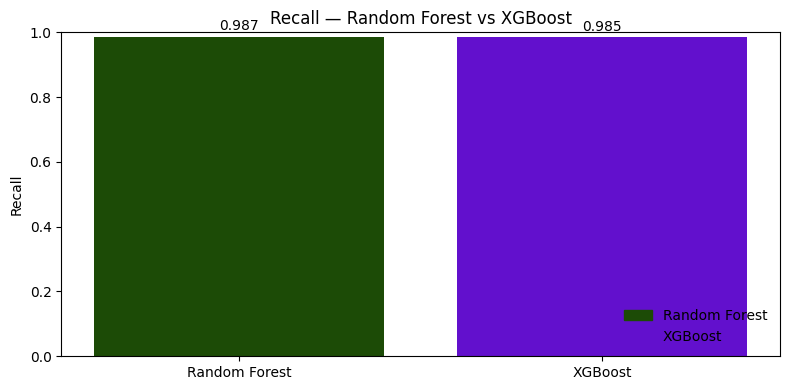

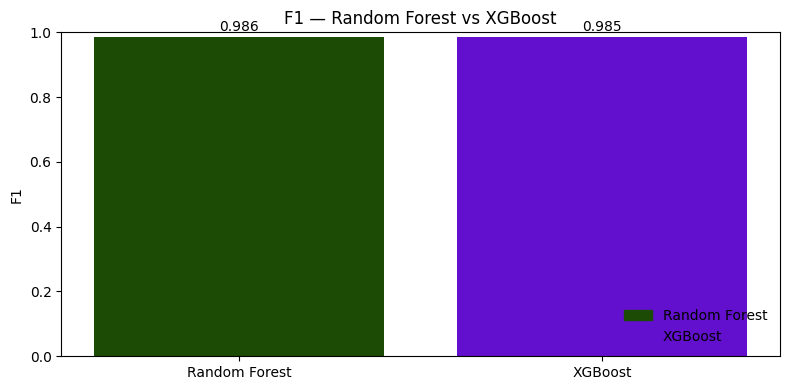

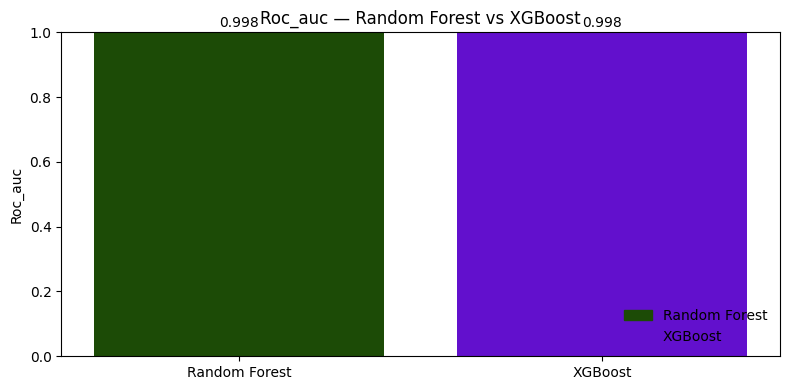

In [80]:
# Bar charts with distinct colors for RF vs XGB
import matplotlib.pyplot as plt
import numpy as np

COLOR_RF  = "#1C4B06"
COLOR_XGB = "#6210CD" 

def plot_metric(metric_name, results_df):
    """Draw a single bar chart per metric."""
    vals = results_df[metric_name]
    labels = vals.index.tolist()
    scores = vals.values

    colors = [COLOR_RF if "Random Forest" in lbl else COLOR_XGB for lbl in labels]

    plt.figure(figsize=(8,4))
    bars = plt.bar(labels, scores, color=colors)
    plt.title(f"{metric_name.capitalize()} — Random Forest vs XGBoost")
    plt.ylabel(metric_name.capitalize())
    plt.ylim(0, 1)
    # value labels on top
    for b, s in zip(bars, scores):
        plt.text(b.get_x() + b.get_width()/2, s + 0.01, f"{s:.3f}", ha="center", va="bottom")
    # legend
    plt.legend(handles=[
        plt.Rectangle((0,0),1,1, color=COLOR_RF,  label="Random Forest"),
        plt.Rectangle((0,0),1,1, color=COLOR_XGB, label="XGBoost")
    ], frameon=False, loc="lower right")
    plt.tight_layout()
    plt.show()

for m in ["accuracy", "precision", "recall", "f1", "roc_auc"]:
    plot_metric(m, results)


## Confusion Matrix & ROC curve

In [82]:
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, index=["Actual Reject","Actual Approve"],
                columns=["Pred Reject","Pred Approve"])

,Pred Reject,Pred Approve
Actual Reject,315,8
Actual Approve,7,524


In [83]:
y_pred_xgb = xgb_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred_xgb, labels=[0, 1])  # 0=Reject, 1=Approve
cm_df = pd.DataFrame(
    cm,
    index=["Actual Reject", "Actual Approve"],
    columns=["Pred Reject", "Pred Approve"]
)
display(cm_df)

,Pred Reject,Pred Approve
Actual Reject,315,8
Actual Approve,8,523


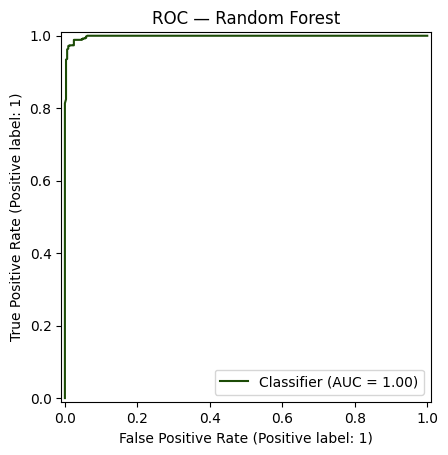

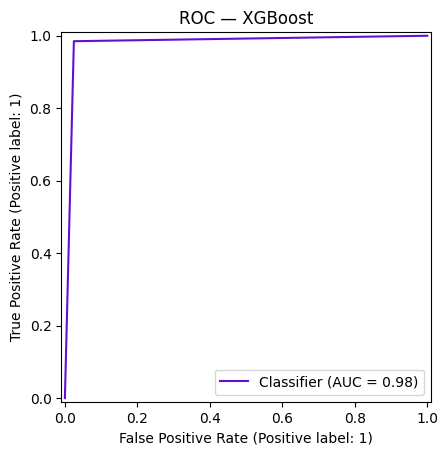

In [92]:
RocCurveDisplay.from_predictions(y_test, y_prob,color=COLOR_RF)
plt.title("ROC — Random Forest")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_pred_xgb,color=COLOR_XGB)
plt.title("ROC — XGBoost")
plt.show()

## Feature importance (top drivers)
### Understand which features influance decision

In [93]:
ohe = rf_pipe.named_steps["prep"].named_transformers_.get("cat")
cat_names = ohe.named_steps["onehot"].get_feature_names_out(cat_cols) if (ohe and len(cat_cols)) else np.array([])
feat_names = np.concatenate([np.array(num_cols), cat_names])

importances = rf_pipe.named_steps["model"].feature_importances_
fi = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False)
fi.head(20)

,feature,importance
5,cibil_score,0.797974
4,loan_term,0.047665
3,loan_amount,0.029111
0,loan_id,0.020245
6,residential_assets_value,0.018517
8,luxury_assets_value,0.018498
7,commercial_assets_value,0.017892
2,income_annum,0.017270
9,bank_asset_value,0.015736
1,no_of_dependents,0.008785


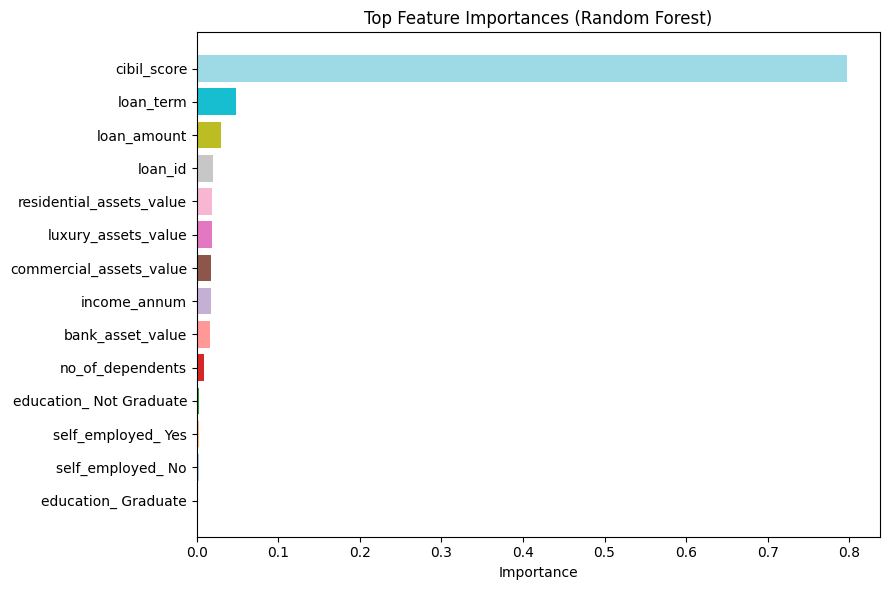

In [98]:
import matplotlib.pyplot as plt
import numpy as np

top_k = 15
top = fi.sort_values("importance", ascending=False).head(top_k)

x = np.arange(len(top))
colors = plt.cm.tab20(np.linspace(0, 1, len(top)))   # different color per bar

plt.figure(figsize=(9,6))
plt.barh(top["feature"].iloc[::-1], top["importance"].iloc[::-1], color=plt.cm.tab20(np.linspace(0,1,len(top))))
plt.xlabel("Importance")
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout(); plt.show()
plt.show()

## Save the trained pipeline to resuse the exact preprocessing + model for interface and FastAPI.

In [103]:
rf_path = MODELS / "loan_approval_rf_pipeline.joblib"
dump(rf_pipe, rf_path)
print(rf_path)

xgb_path = MODELS / "loan_approval_xgb_pipeline.joblib"
dump(xgb_pipe, xgb_path)
print(xgb_path)

/Users/priyankrupera/Documents/ML_Project/models/loan_approval_rf_pipeline.joblib
/Users/priyankrupera/Documents/ML_Project/models/loan_approval_xgb_pipeline.joblib


In [106]:
from pathlib import Path
import json

feature_columns = X.columns.tolist()
Path(MODELS).mkdir(parents=True, exist_ok=True)

feat_path = Path(MODELS) / "feature_columns.json"
feat_path.write_text(json.dumps({"features": feature_columns}, indent=2))
print("Wrote:", feat_path)
print("Num features:", len(feature_columns))


Wrote: /Users/priyankrupera/Documents/ML_Project/models/feature_columns.json
Num features: 12


## EMI Helper for adding rules on prediction 

In [110]:
def compute_emi(principal: float, annual_rate: float, months: int) -> float:
    """
    EMI formula:
      E = P * r * (1+r)^n / ((1+r)^n - 1)
    where r = monthly interest rate (annual_rate/12), n = months
    """
    if principal is None or months is None or months <= 0:
        return None
    r = (annual_rate or 0.0) / 12.0
    if r <= 0:
        return principal / months
    pow_ = (1 + r) ** months
    return principal * r * pow_ / (pow_ - 1)

def apply_emi_policy_years(income_annum: float,
                           loan_amount: float,
                           loan_term_years: float,
                           annual_rate: float = 0.082):
    """
    Rule: EMI must be <= 50% of monthly income.
    - tenure is provided in YEARS; convert to months internally.
    - monthly_income derived from annual income.
    """
    if income_annum is None or loan_amount is None or loan_term_years is None or loan_term_years <= 0:
        return {
            "emi": None, "monthly_income": None, "threshold": None,
            "rule_applied": False, "rule_reject": False,
            "reason": "Policy skipped (missing income_annum/loan_amount/loan_term_years)."
        }

    months = int(round(float(loan_term_years) * 12))
    monthly_income = float(income_annum) / 12.0
    emi = compute_emi(float(loan_amount), annual_rate, months)

    if emi is None:
        return {
            "emi": None, "monthly_income": monthly_income, "threshold": None,
            "rule_applied": False, "rule_reject": False,
            "reason": "Policy skipped (EMI not computable)."
        }

    threshold = 0.5 * monthly_income
    rule_reject = emi > threshold
    return {
        "emi": float(emi),
        "monthly_income": float(monthly_income),
        "threshold": float(threshold),
        "rule_applied": True,
        "rule_reject": bool(rule_reject),
        "reason": "EMI exceeds 50% of monthly income" if rule_reject else "EMI within safe limit"
    }


## inference helper that enforces the policy

In [123]:
def predict_approval_with_policy_years(pipeline, sample: dict,
                                       threshold: float = 0.5,
                                       annual_rate: float = 0.082):
    """
    1) Get model probability + model_pred (0/1).
    2) Apply business policy using tenure in YEARS (converted to months for EMI).
    3) If policy fails, force final_pred = 0 (Reject).
    """
    import pandas as pd
    x = pd.DataFrame([sample])
    prob = float(pipeline.predict_proba(x)[:, 1][0])
    model_pred = int(prob >= threshold)

    income_annum = sample.get("income_annum")
    loan_amount  = sample.get("loan_amount")
    loan_term_y  = sample.get("loan_term") or sample.get("loan_term_years")  # your dataset uses years

    policy = apply_emi_policy_years(income_annum, loan_amount, loan_term_y, annual_rate=annual_rate)

    final_pred = 0 if (policy["rule_applied"] and policy["rule_reject"]) else model_pred

    return {
        "prob_approve": prob,
        "model_pred": model_pred,
        "final_pred": final_pred,
        "policy": policy
    }


## Test

In [130]:
example = {
    "loan_id": 101234,
    "no_of_dependents": 2,
    "education": "Graduate",
    "self_employed": "No",
    "income_annum": 840000,   
    "loan_amount": 600000,    
    "loan_term": 1,
    "cibil_score": 720,
    "residential_assets_value": 500000,
    "commercial_assets_value": 0,
    "luxury_assets_value": 0,
    "bank_asset_value": 120000
}

predict_approval_with_policy_years(rf_pipe, example, threshold=0.5, annual_rate=0.0642)


{'prob_approve': 0.855,
 'model_pred': 1,
 'final_pred': 0,
 'policy': {'emi': 51755.75761141699,
  'monthly_income': 70000.0,
  'threshold': 35000.0,
  'rule_applied': True,
  'rule_reject': True,
  'reason': 'EMI exceeds 50% of monthly income'}}